# Pytorch Text - Classifying Names With a Character-Level RNN
Notebook for following along with Pytorch Text text interpretation tutorial, looking at basic character level RNN [Pytorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)  website tutorial. <br><br>
The data can be downloaded [here](https://download.pytorch.org/tutorial/data.zip).

### Choices for data

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [1]:
#Import cell
import glob
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
import os
import pandas as pd
import pickle as pk
import random
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import unicodedata

from __future__ import unicode_literals, print_function, division
from io import open

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(f"Device: {device}. Cuda available: {torch.cuda.is_available()}")
print("Imports complete")

Device: cuda. Cuda available: False
Imports complete


<br>

### Importing and preparing data sets
Importing and preparing the data for the models.

In [2]:
#Gather datasets and prepare them for consumption
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!= 'Mn' and c in all_letters)

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

print("Data sets functions defined.")

Data sets functions defined.


In [3]:
#Importing data sets
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(findFiles('data/names/*.txt'))
print("\n"+unicodeToAscii('Ślusàrski')+"\n")
print(category_lines['Italian'][:5])
print("\nData sets successfully imported.")

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']

Slusarski

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

Data sets successfully imported.


In [4]:
#Loader definitions

print(f"Loaders defined, running on device: {device}")

Loaders defined, running on device: cuda


In [5]:
#Setting seed value
torch.manual_seed(1247)

<br>

### Class Definitions
<b>Classes:</b><br>
<ul>
    <li>TransformerModel - Language interpretting model.</li>
    <li>PositionalEncoding - Injects information about the relative or absolute position of tokens in the sequence.</li>
</ul>

In [6]:
#Class definition cell
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        return None
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
print("Classes defined.")

Classes defined.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
    <li>all_letters - find letter index from all_letters</li>
    <li>letterToTensor - turn a letter into a 1 x n_letters tensor</li>
    <li>lineToTensor - turn a line into a line_length x 1 x n_letters Tensor</li>
</ul>

In [7]:
#Calculation functions cell
def letterToIndex(letter):
    return all_letters.find(letter)


def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
        return tensor

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
    <li></li>
</ul>

In [8]:
#Plotting functions Cell

print("Plotting functions defined.")

Plotting functions defined.


<br>

### Main code
#### Turning Names into Tensors

In [9]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


#### Creating the network

In [10]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9116, -2.8946, -2.9090, -2.8637, -2.9302, -2.8680, -2.8485, -2.8203,
         -2.9598, -2.8825, -2.9060, -2.9510, -2.8760, -2.7504, -2.9150, -2.8833,
         -2.9548, -2.9247]], grad_fn=<LogSoftmaxBackward0>)


#### Training

In [12]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Portuguese', 13)


In [13]:
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [14]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f"category = {category}/ line = {line}")

category = Japanese/ line = Tsuruya
category = French/ line = Lesauvage
category = Polish/ line = Bobienski
category = German/ line = Gass
category = French/ line = Deniau
category = Vietnamese/ line = Giang
category = Czech/ line = Heidl
category = Vietnamese/ line = Dao
category = English/ line = Coleman
category = Spanish/ line = Abreu


#### Training The Network

In [15]:
criterion = nn.NLLLoss()
learning_rate = 0.005

In [20]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
        
    return output, loss.item()

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' %(m, s)

In [17]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [21]:
current_loss = 0
all_losses = []
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter%print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s | %s %s' % (iter, iter/n_iters*100, 
                    timeSince(start), loss, line, guess, correct))
    if iter%plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.8490 Johnstone | Russian ✗ (Scottish)
10000 10% (0m 10s) 1.3554 Woo | Chinese ✗ (Korean)
15000 15% (0m 15s) 2.1340 Phan | Chinese ✗ (Vietnamese)
20000 20% (0m 20s) 2.7022 Sioda | Arabic ✗ (Irish)
25000 25% (0m 25s) 3.1583 Rhys | Korean ✗ (Irish)
30000 30% (0m 31s) 1.9946 Achteren | Dutch ✓
35000 35% (0m 36s) 2.8647 Asch | Arabic ✗ (Dutch)
40000 40% (0m 41s) 2.6667 Leclair | Scottish ✗ (French)
45000 45% (0m 47s) 2.6178 Edmond | Czech ✗ (English)
50000 50% (0m 52s) 2.1683 Altimari | Japanese ✗ (Italian)
55000 55% (0m 58s) 2.4688 Ventura | Irish ✗ (Portuguese)
60000 60% (1m 3s) 2.5573 Franco | Arabic ✗ (Portuguese)
65000 65% (1m 8s) 3.0444 Benesch | French ✗ (Czech)
70000 70% (1m 14s) 3.1214 Rooiakker | Russian ✗ (Dutch)
75000 75% (1m 19s) 3.5943 Baldovini | Dutch ✗ (Italian)
80000 80% (1m 24s) 2.7468 Haanraads | Russian ✗ (Dutch)
85000 85% (1m 29s) 2.4171 Porcher | Greek ✗ (French)
90000 90% (1m 35s) 1.7372 Pirojenko | Russian ✓
95000 95% (1m 40s) 0.3854 Vinh | Vietnam

#### Plotting Results

Training Losses


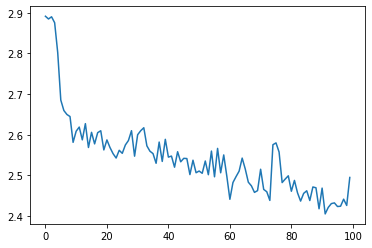

In [22]:
plt.figure()
plt.plot(all_losses)
print("Training Losses")

#### Evaluating the Results

<br>